## 四、知识要点

## 4.1 疾病引起原因解释模型

In [1]:
import warnings
warnings.filterwarnings("ignore") # 忽视 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import export_graphviz 
from sklearn.model_selection import train_test_split 
import eli5 
from eli5.sklearn import PermutationImportance
import shap #对比多个/所有特征对模型起到抑制和促进
from pdpbox import pdp, info_plots
np.random.seed(123)#跟random_state是一样的，第一次运行的时候，后面的结果是不会变的

pd.options.mode.chained_assignment = None  #会关闭掉copywarning警告报红

Using TensorFlow backend.


- 一、加载数据集/pandas.read_csv("*****")

In [3]:
dt = pd.read_csv("./datasets/heart.csv")
dt.head()
#年、性别、胸痛经历、血压、胆固醇、血糖、心电图、心率、运动诱发心绞痛、运动相对于休息引起的ST段压低、主要数量、血液疾病、目标(是否得心脏病)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

In [4]:
# # 正常思路
# X, y = np.split(dt, (13,), axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=10)
# model = RandomForestClassifier(max_depth=5)
# model.fit(X_train, y_train) 
# from sklearn.metrics import precision_score # 精确率
# print(precision_score(y_test, y_predict)) 

- age：该人的年龄
- sex：该人的性别（1 =男性，0 =女性）
- cp：胸痛经历（值1：典型心绞痛，值2：非典型心绞痛，值3：非心绞痛，值4：无症状）
- trestbps：该人的静息血压（入院时为mm Hg）
- chol：人体胆固醇测量单位为mg / dl
- fbs：该人的空腹血糖（> 120 mg / dl，1 = true; 0 = false）
- restecg：静息心电图测量（0 =正常，1 =有ST-T波异常，2 =按Estes标准显示可能或明确的左心室肥厚）
- thalach：达到了该人的最大心率
- exang：运动诱发心绞痛（1 =是; 0 =否）
- oldpeak：运动相对于休息引起的ST段压低（'ST'与ECG图上的位置有关。）
- slope：峰值运动ST段的斜率（值1：上升，值2：平坦，值3：下降）
- ca：主要数量（0-3）
- thal：称为地中海贫血的血液疾病（ 1=正常; 2 =固定缺陷; 3 =可逆缺陷）
- target：心脏病（0 =不，1 =是）

![no](分割线.png)

In [5]:
#拿到当前所有的13个特征和1个标签 ，一共是14列 
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

- 结构化的原始数据，比较干净，咱们打乱一下顺序，有的特征和标签的属性都转化为“str”类型

In [6]:
#转换一下各个特征的属性，int——>str

dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

#    胸痛经历                                              
dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina' #典型心绞痛
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina' #非典型心绞痛
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain' #非心绞痛
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'  #无症状

#病人的静息血压
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml' #低压
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'#高压

#心电图测量
dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'#正常
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality' #有ST-T波异常
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'#按Estes标准显示可能或明确的左心室肥厚

#运动诱发心绞痛
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no' #否
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes' #是

#峰值运动后ST段心电图的斜率
dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'#上升
dt['st_slope'][dt['st_slope'] == 2] = 'flat' #平坦
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping' #下降

#称为地中海贫血的血液疾病
dt['thalassemia'][dt['thalassemia'] == 1] = 'normal' #正常
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect' #固定
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'#可逆缺陷


In [7]:
dt.dtypes #可以看出除了int类型外，有很多的object类型，比如说sex chest_pain_type等

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [8]:

dt['sex'] = dt['sex'].astype('object')# 现在强反转过来男为1 ，女为0 
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object') 
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')

In [9]:
print(dt['sex'].astype('object')) #原来是”sex“：female为女，male为男 ，现在强反转过来男为1 ，女为0 

0        male
1        male
2      female
3        male
4      female
        ...  
298    female
299      male
300      male
301      male
302    female
Name: sex, Length: 303, dtype: object


In [10]:
#pandas的读热编码
dt = pd.get_dummies(dt) # prefix
dt.head()

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
0   63                     145          233                      150   
1   37                     130          250                      187   
2   41                     130          204                      172   
3   56                     120          236                      178   
4   57                     120          354                      163   

   st_depression  num_major_vessels  target  sex_female  sex_male  \
0            2.3                  0       1           0         1   
1            3.5                  0       1           0         1   
2            1.4                  0       1           1         0   
3            0.8                  0       1           0         1   
4            0.6                  0       1           1         0   

   chest_pain_type_0  ...  rest_ecg_normal  exercise_induced_angina_no  \
0                  0  ...                1                           1   
1                  0  ...                0                           1   
2                  0  ...                1                           1   
3                  0  ...                0                           1   
4                  1  ...                0                           0   

   exercise_induced_angina_yes  st_slope_0  st_slope_flat  st_slope_upsloping  \
0                            0           1              0                   0   
1                            0           1              0                   0   
2                            0           0              1                   0   
3                            0           0              1                   0   
4                            1           0              1                   0   

   thalassemia_0  thalassemia_fixed defect  thalassemia_normal  \
0              0                         0                   1   
1              0                         1                   0   
2              0                         1                   0   
3              0                         1                   0   
4              0                         1                   0   

   thalassemia_reversable defect  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  

[5 rows x 27 columns]

- 二、分割数据集/train_test_split(X , y ,test_size = .2, random_state=10)

In [11]:
#drop()传进来2个值，既drop(labels , axis) , axis=0(删除行),axis=1(删除列)
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), 
                                dt['target'], test_size = .2, random_state=10) 

- 三、选择/建立模型 model = RandomForestClassifier(max_depth=5)

In [12]:
model = RandomForestClassifier(max_depth=5)

- 四、训练模型/model.fit(X_train, y_train)

In [13]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

- bootstrap=True是否使用bootstrap，默认是true，自助法，有放回的重采样
- “balanced” 模式自动调整权重，每类的权重为 n_samples / (n_classes * np.bincount(y))，即类别数的倒数除以每类样本数的占比。
- 树分裂的规则：gini系数，entropy熵,默认的是基尼系数
- max_depth=5：树的深度为5层
- max_features='auto'：int, float, string or None, optional (default=”auto”)查找最佳分裂所需考虑的特征数，
- int：分裂的最大特征数，
- float：分裂的特征占比，auto、sqrt：sqrt(n_features)，log2：log2(n_features)，None：n_features，

- max_leaf_nodes=None 最大叶子节点数；
- min_impurity_decrease=0 分裂的最小不纯度为0 
- n_estimators：随机森林中树的数量
- n_jobs : integer, optional (default=1)，并行job数，-1 代表全部
- oob_score : bool (default=False)，是否使用袋外（out-of-bag）样本估计准确度；
- random_state=None ，随机数种子，保持下一次运行不变
- verbose：控制树冗余
- warm_start : bool, optional (default=False)，如果设置为True，在之前的模型基础上预测并添加模型，否则，建立一个全新的森林；



In [14]:
print(model)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [15]:
estimator = model.estimators_[1]#只有一颗树
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease' #0代表没心脏病
y_train_str[y_train_str == '1'] = 'disease' #1代表有心脏病
y_train_str = y_train_str.values

In [16]:
#graphviz 手动安装 ，这是一个模板，需要填的就填好了
#proportion=True ，设置均匀
#filled：装满
#feature_names特征名称，已定义

export_graphviz(estimator, out_file='tree.dot', 

                feature_names = feature_names,  #特征变量 ，已被定义
                class_names = y_train_str, # 类别变量，已被定义
                rounded = True, proportion = True, #树节点为圆角矩形
                label='root',
                precision = 2, filled = True) #precision=2：每个节点的杂质，阈值和值属性的值中浮点数的精度位数； filled：充满

# 使用系统命令转换为png（需要Graphviz）
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'],shell=True)
# dot:生成可视化图片的命令  
#-Tpng：指定图像类型是png
#tree.dot：out_file输出的文件名
#-o：output输出文件
#tree.png：输出文件名
#-Gdpi=600：图像每英寸含600个像素


# 显示在jupyter笔记本
from IPython.display import Image
Image(filename = 'tree.png')

- 五、验证模型/model.predict(X_test)

In [17]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)#，前面是高维，后面是低纬 ， 1代表第一列
print(y_pred_quant[:5])#第一行属于0的概率是0.89349206，也就是没得心脏病的概率为0.89349206；属于1的概率是0.10650794，也就是得心脏病
print("-------------------------")
print(y_pred_quant[:, 1])#取第2列，也就是1
y_pred_bin = model.predict(X_test)
print("-------------------------")
print(y_pred_bin) #输出的是测试集中的y_test

[[0.99259259 0.00740741]
 [0.53978022 0.46021978]
 [0.77843137 0.22156863]
 [0.27088649 0.72911351]
 [0.78207014 0.21792986]]
-------------------------
[0.00740741 0.46021978 0.22156863 0.72911351 0.21792986 0.80995671
 0.62915507 0.84757537 0.85949916 0.07166667 0.86574916 0.30508021
 0.72267281 0.9304177  0.15046296 0.9304177  0.         0.
 0.56879085 0.105      0.03333333 0.84421888 0.82970674 0.8323396
 0.25388889 0.04666667 0.125      0.10388889 0.89935709 0.
 0.89783249 0.15701754 0.075      0.04666667 0.         0.16804318
 0.72662982 0.43333333 0.86363636 0.21461538 0.         0.24666667
 0.94672043 0.56955026 0.89908249 0.57426141 0.51323529 0.87408249
 0.8246402  0.31606061 0.597151   0.84412815 0.08333333 0.13412698
 0.99354839 0.84476446 0.68823529 0.64214146 0.         0.
 0.53955026]
-------------------------
[0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1
 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1]


In [18]:
from sklearn.metrics import precision_score # 精确率
print(precision_score(y_test, y_predict))   

0.7096774193548387


In [19]:
from sklearn.metrics import recall_score # 召回率
print(recall_score(y_test, y_predict)) 

0.8461538461538461


In [20]:
#把随机森林加载进来 ，下一次运行结果不变 
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
#               要求集成算法的特征重要度  ， 把所有特征加载进来
eli5.show_weights(perm, feature_names = X_test.columns.tolist())
#第一行的心绞痛的经历权重很高跟是否得心脏病很重要，中间的非心绞痛就跟心脏病和正常的贫血跟没关系

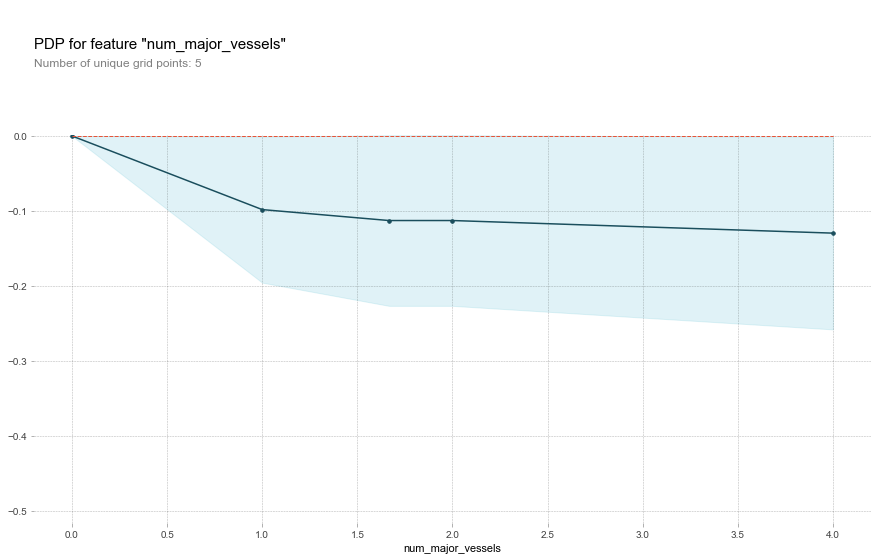

In [21]:
#dt是原始数据，查看一下“主要血管数”
base_features = dt.columns.values.tolist()
base_features.remove('target')#删除标签，是否得心脏病，剩下的都是特征

feat_name = 'num_major_vessels'#主要血管数量
#                                                       除了标签的所有特征
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)
#                      特征名称：主要血管数
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

#随着主要血管的数量增加，心脏病的概率降低,也就是该特征对结果起到了抑制的作用。这是有道理的，因为这意味着更多的血液可以进入心脏。


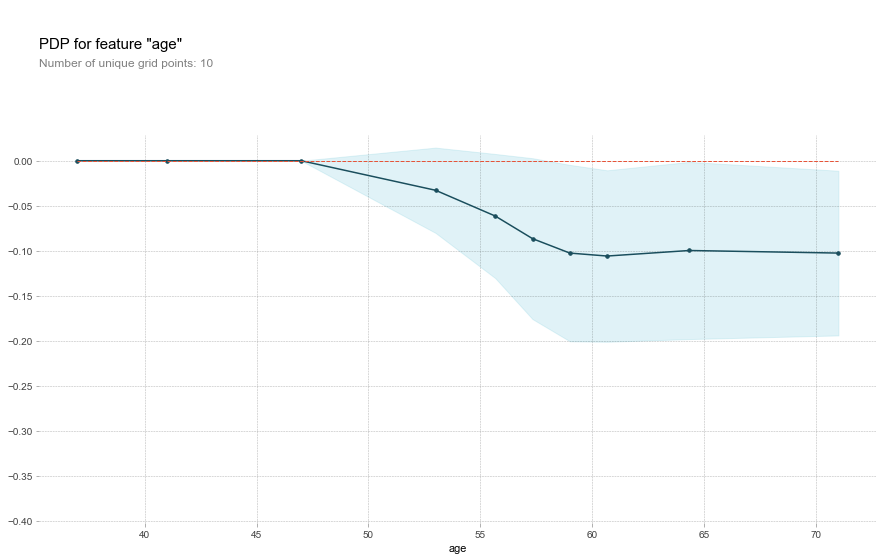

In [22]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

#随着年龄的升高，心脏病越小

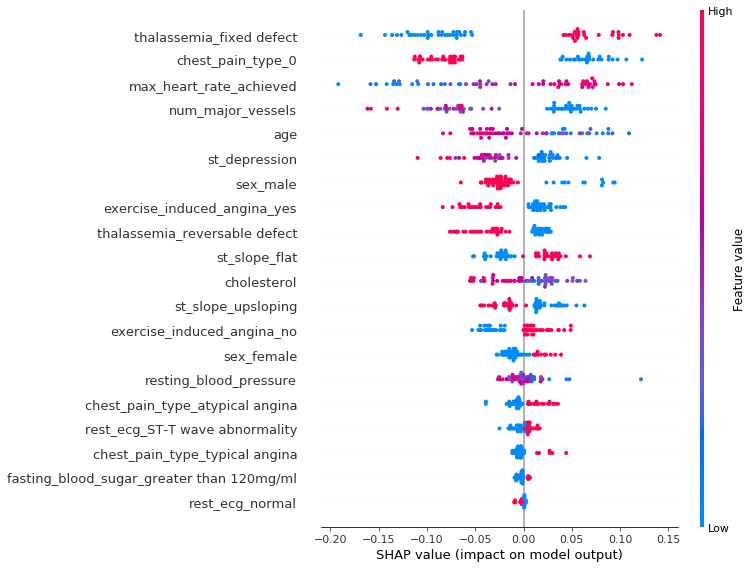

In [23]:
#chest_pain_type：心绞痛从蓝变红，越来越大，代表越来越严重
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

In [24]:
#1是代表没得心脏病
#红色代表患心脏病低，蓝色代表患心脏病高
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)#shap_values是所有的测试特征
    shap.initjs()#显示格式转换 
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient) #patient患者

In [25]:
data_for_prediction = X_test.iloc[1,:].astype(float)#把测试样本中，第一行的所有特征拿到都强制转为”float“
heart_disease_risk_factors(model, data_for_prediction)
#图中红色的chest_pain_type = 2非典型心绞痛对没有患心脏病的强度很大；蓝色的num_magor_vessels=1血管数量越少，对换心脏病的强度越高

In [26]:
from sklearn.metrics import precision_score # 精确率

y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]

#宏平均（Macro-averaging），是先对每一个类统计指标值，然后在对所有类求算术平均值。
#微平均（Micro-averaging），是对数据集中的每一个实例不分类别进行统计建立全局混淆矩阵，然后计算相应指标。

print(precision_score(y_true, y_pred, average='macro'))  
print(precision_score(y_true, y_pred, average='micro'))  

0.2222222222222222
0.3333333333333333


In [27]:
from sklearn.metrics import recall_score # 召回率

y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]

print(recall_score(y_true, y_pred, average='macro'))  # 0.3333333333333333
print(recall_score(y_true, y_pred, average='micro'))  # 0.3333333333333333

0.3333333333333333
0.3333333333333333


In [28]:
from sklearn.metrics import f1_score # 调和平均值

y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
print(f1_score(y_true, y_pred, average='macro'))  
print(f1_score(y_true, y_pred, average='micro'))  

0.26666666666666666
0.3333333333333333


In [30]:
call(['dot', '-Tpng', r'C:\Users\Administrator\Desktop\ta\tree.dot', '-o', r'C:\Users\Administrator\Desktop\ta\tree.png', '-Gdpi=600'],shell=True)

0